In [7]:
!pip install gym keras-rl2 gym[atari]

In [8]:
import gym 
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
#from pyvirtualdisplay import Display

In [9]:
#import urllib.request
#urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
#!pip install unrar
#!unrar x Roms.rar
#!mkdir rars
#!mv HC\ ROMS.zip   rars
#!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


copying adventure.bin from rars\Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\adventure.bin
copying air_raid.bin from rars\Air Raid (Men-A-Vision) (PAL) ~.bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\air_raid.bin
copying alien.bin from rars\Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\alien.bin
copying amidar.bin from rars\Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\amidar.bin
copying assault.bin from rars\Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\assault.bin
copying asterix.bin from rars\Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domur

Traceback (most recent call last):
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\import_roms.py", line 93, in <module>
    main()
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\import_roms.py", line 89, in main
    import_roms(args.dirpath)
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\import_roms.py", line 74, in import_roms
    with open(filepath, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: 'rars\\Pursuit of the Pink Panther (Pink Panther - The Video Game, Adventures of the Pink Panther) (1983) (Probe 2000 - NAP, Roger Booth, Todd Marshall, Robin McDaniel, Jim Wickstead) (3152VC) (Prototype) ~.bin'


In [10]:
env = gym.make('Asteroids-v0')
height, width, channels = env.observation_space.shape
actions = env.action_space.n

In [12]:
env.unwrapped.get_action_meanings()

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE']

Episode:2 Score:20.0


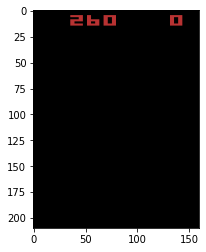

In [13]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
episodes = 2
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        # action = env.action_space.sample()
        action = random.choice([0,1,2,3,4,5])
        n_state, reward, done, info = env.step(action)
        score+=reward
        env.step(action)
        env.step(action)
    print('Episode:{} Score:{}'.format(episode, score))
        
env.close()



In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

In [15]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [16]:
del model

NameError: name 'model' is not defined

In [17]:
model = build_model(height, width, channels, actions)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten (Flatten)            (None, 67584)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               34603520  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 14)                3

In [19]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [20]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [24]:
dqn = build_agent(model, actions)

TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [ ]:
dqn.compile(Adam(lr=1e-4))

In [23]:
dqn.fit(env, nb_steps=10000, visualize=False, verbose=2)

NameError: name 'dqn' is not defined